In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
import warnings
warnings.filterwarnings("ignore")

In [2]:
USE_DATA_LEAK='Y' ## Set to Y to exploit data leak
##
RAND_VAL=69
num_folds=20 ## Number of folds
n_est=3500 ## Number of estimators

In [3]:
raw_train = pd.read_csv('train.csv')
raw_test = pd.read_csv('test.csv')


In [4]:
df_train = raw_train.copy()
df_test  = raw_test.copy()
for_EDA = raw_train.copy()

In [5]:
from imblearn.over_sampling import RandomOverSampler

In [6]:
X1 = df_train.drop(columns='class')

In [7]:
y1 = df_train['class']

In [8]:
ros = RandomOverSampler(sampling_strategy=1)
df_train,y2 = ros.fit_resample(X1,y1)

In [9]:
df_train

,ID,age,gender,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity
0,0,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No
1,1,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No
2,2,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
3,3,66,Male,Yes,Yes,Yes,Yes,No,No,Yes,Yes,Yes,No,Yes,Yes,No,No
4,4,67,Male,Yes,Yes,No,Yes,Yes,Yes,No,Yes,Yes,No,Yes,Yes,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,329,45,Male,No,No,No,No,Yes,Yes,No,No,No,No,No,No,No,No
460,225,28,Female,No,No,No,No,Yes,No,No,No,No,No,Yes,No,No,No
461,219,28,Male,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No
462,144,37,Male,No,No,No,No,No,No,No,No,No,No,No,No,No,No


In [10]:
y2.value_counts()

class
Positive    232
Negative    232
Name: count, dtype: int64

In [11]:
scale_cols = ['age']
###
for c in scale_cols:
    min_value = df_train[c].min()
    max_value = df_train[c].max()
    df_train[c+"_scaled"] = (df_train[c] - min_value) / (max_value - min_value)
    df_test[c+"_scaled"] = (df_test[c] - min_value) / (max_value - min_value)

In [12]:
feat_cols=df_train.columns.drop(['ID'])
feat_cols=feat_cols.drop(scale_cols)
print(feat_cols)
df_train.head()

Index(['gender', 'polyuria', 'polydipsia', 'sudden_weight_loss', 'weakness',
       'polyphagia', 'genital_thrush', 'visual_blurring', 'itching',
       'irritability', 'delayed_healing', 'partial_paresis',
       'muscle_stiffness', 'alopecia', 'obesity', 'age_scaled'],
      dtype='object')


,ID,age,gender,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity,age_scaled
0,0,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,0.337838
1,1,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,0.391892
2,2,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0.594595
3,3,66,Male,Yes,Yes,Yes,Yes,No,No,Yes,Yes,Yes,No,Yes,Yes,No,No,0.675676
4,4,67,Male,Yes,Yes,No,Yes,Yes,Yes,No,Yes,Yes,No,Yes,Yes,No,Yes,0.689189


In [13]:
X=df_train[feat_cols]
y=y2
##
cat_features = np.where(X.dtypes != np.float64)[0]
cat_features

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
      dtype=int64)

In [14]:
import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

In [15]:
from sklearn.metrics import accuracy_score

In [16]:
X

,gender,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity,age_scaled
0,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,0.337838
1,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,0.391892
2,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0.594595
3,Male,Yes,Yes,Yes,Yes,No,No,Yes,Yes,Yes,No,Yes,Yes,No,No,0.675676
4,Male,Yes,Yes,No,Yes,Yes,Yes,No,Yes,Yes,No,Yes,Yes,No,Yes,0.689189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,Male,No,No,No,No,Yes,Yes,No,No,No,No,No,No,No,No,0.391892
460,Female,No,No,No,No,Yes,No,No,No,No,No,Yes,No,No,No,0.162162
461,Male,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,0.162162
462,Male,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0.283784


In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=77)

In [18]:
def objective(trial):
    model = CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 0, 2000),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        depth=trial.suggest_int("depth", 2, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    return accuracy_score(y_valid, y_pred)

In [19]:
folds = StratifiedKFold(n_splits=num_folds,random_state=RAND_VAL,shuffle=True)
test_preds = np.empty((num_folds, len(df_test)))
auc_vals=[]

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[valid_idx], y.iloc[valid_idx]
    
    train_pool = Pool(X_train, y_train,cat_features=cat_features)
    val_pool = Pool(X_val, y_val,cat_features=cat_features)
    
    clf = CatBoostClassifier(
    eval_metric='AUC',
    learning_rate=0.03,
    iterations=n_est)
    clf.fit(train_pool, eval_set=val_pool,verbose=300)
    
    y_pred_val = clf.predict_proba(X_val[feat_cols])[:,1]
    auc_val = roc_auc_score(y_val, y_pred_val)
    print("AUC for fold ",n_fold,": ",auc_val)
    auc_vals.append(auc_val)
    
    y_pred_test = clf.predict_proba(df_test[feat_cols])[:,1]
    test_preds[n_fold, :] = y_pred_test
    print("----------------")

0:	test: 0.9826389	best: 0.9826389 (0)	total: 140ms	remaining: 8m 9s
300:	test: 1.0000000	best: 1.0000000 (2)	total: 588ms	remaining: 6.25s
600:	test: 1.0000000	best: 1.0000000 (2)	total: 1.03s	remaining: 4.99s
900:	test: 1.0000000	best: 1.0000000 (2)	total: 1.47s	remaining: 4.23s
1200:	test: 1.0000000	best: 1.0000000 (2)	total: 1.88s	remaining: 3.6s
1500:	test: 1.0000000	best: 1.0000000 (2)	total: 2.27s	remaining: 3.02s
1800:	test: 1.0000000	best: 1.0000000 (2)	total: 2.66s	remaining: 2.51s
2100:	test: 1.0000000	best: 1.0000000 (2)	total: 3.04s	remaining: 2.02s
2400:	test: 1.0000000	best: 1.0000000 (2)	total: 3.41s	remaining: 1.56s
2700:	test: 1.0000000	best: 1.0000000 (2)	total: 3.79s	remaining: 1.12s
3000:	test: 1.0000000	best: 1.0000000 (2)	total: 4.12s	remaining: 685ms
3300:	test: 1.0000000	best: 1.0000000 (2)	total: 4.45s	remaining: 268ms
3499:	test: 1.0000000	best: 1.0000000 (2)	total: 4.67s	remaining: 0us

bestTest = 1
bestIteration = 2

Shrink model to first 3 iterations.
AUC 

In [20]:
"Mean AUC: ",np.mean(auc_vals)

('Mean AUC: ', 0.9992739898989897)

In [21]:
y_pred = test_preds.mean(axis=0)

In [22]:
y_pred

array([0.67001166, 0.67383991, 0.34689455, 0.67222452, 0.35085045,
       0.37230168, 0.35317326, 0.34485219, 0.34758571, 0.64202349,
       0.64260237, 0.35204812, 0.6726834 , 0.36126793, 0.62168965,
       0.66590765, 0.66203352, 0.62001799, 0.35675517, 0.67453103,
       0.49161718, 0.60567999, 0.36389353, 0.34645501, 0.56534068,
       0.34645501, 0.62001799, 0.34869006, 0.6061517 , 0.67186606,
       0.66505388, 0.40529702, 0.36473934, 0.67424521, 0.38717065,
       0.67186606, 0.35317326, 0.36117509, 0.67108504, 0.66792841,
       0.67421306, 0.35576648, 0.35675517, 0.53792821, 0.66508738,
       0.64200797, 0.45975525, 0.63558321, 0.35887596, 0.65988168,
       0.65717284, 0.45467014, 0.56534068, 0.45568716, 0.34718869,
       0.67054942, 0.40068658, 0.37306909, 0.36084741, 0.34645501,
       0.66266244, 0.6044899 , 0.34931912, 0.60402971, 0.60438234,
       0.34718869, 0.5457084 , 0.66590765, 0.67454572, 0.67186606,
       0.34997665, 0.64079197, 0.52272309, 0.34718869, 0.37564

In [23]:
result = y_pred.round()

In [24]:
R1 = pd.DataFrame(df_test['ID'])
result_nn1 = pd.DataFrame(result)

In [25]:
mapping2 = {1:'Positive',0:'Negative'}
resultf = result_nn1.replace(mapping2)

In [26]:
R1['class'] = resultf

In [27]:
R1

,ID,class
0,0,Positive
1,1,Positive
2,2,Negative
3,3,Positive
4,4,Negative
...,...,...
151,151,Negative
152,152,Negative
153,153,Negative
154,154,Positive


In [28]:
R1.to_csv('submission3.csv', index=False)
R1.to_csv(r'C:\Users\peaks\Desktop\Submission\submission9.csv', index=False)

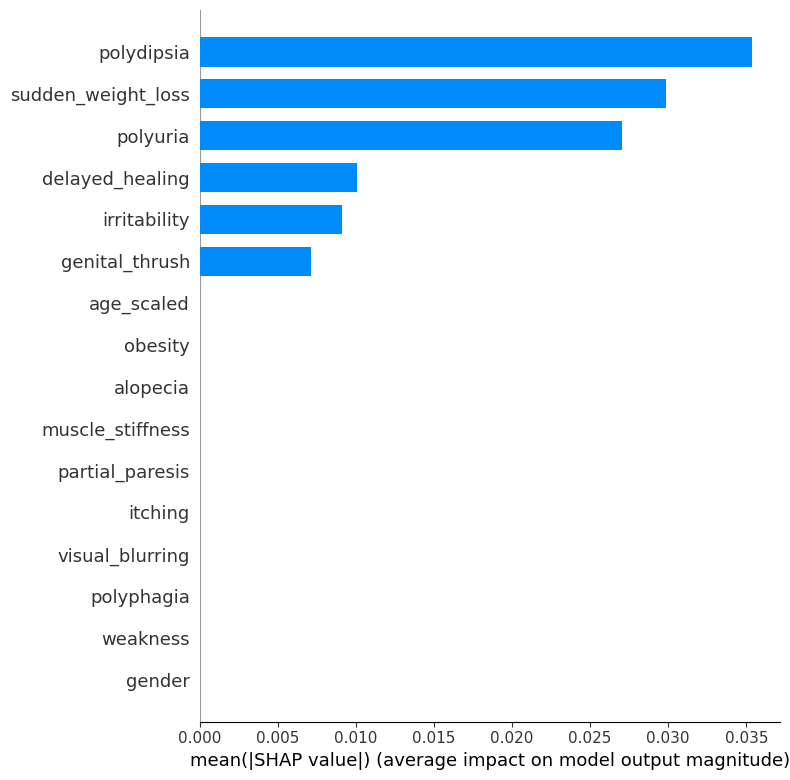

In [29]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(train_pool)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [ ]:
from sklearn import svm

In [ ]:
mapping = {"Yes":1,"No":0,"Positive":1,"Negative":0,"Male":0,"Female":1}

In [ ]:
EDA = for_EDA.replace(mapping).drop(columns='ID')
X_test = df_test.replace(mapping).drop(columns='ID')

In [ ]:
EDA

In [ ]:
X_test

In [ ]:
clf = svm.SVC()

In [ ]:
y = EDA['class']

In [ ]:
EDA = EDA.drop(columns='class')

In [ ]:
EDA

In [ ]:
clf.fit(EDA, y)

In [ ]:
clf.predict(X_test)